# Worksheet 3: Comparing models and observations for the historical period

In the last worksheet we started to undertake basic data analysis and visulisation in python using Iris. This worksheet picks-up where we left off and introduces us to more advanced data analysis.  This worksheet ends with an extended exercise to start you thinking about coding more independently.

<div class="alert alert-block alert-warning">
<b>By the end of this worksheet you should be able to:</b><br> 
- Extract specific regions of interested from large datasets<br>
- Apply more advanced statistical operations to multi-annual data. <br>
- Produce your own data processing workflow.<br>
</div>

## Contents
### [3.1: Region extraction](#3.1)
### [3.2: Mean annual cycle calculation](#3.2)
### [3.3: Comparing models and observations](#3.3)
### [3.4: Climatological mean and annual cycle for an ensemble](#3.4)


## Preamble
Run the code preamble below to import the necessary libraries for this worksheet.

To run the code, click in the box below and press <kbd>Ctrl</kbd> + <kbd>Enter</kbd>.

In [1]:
# Code preamble - these libraries will be used in this worksheet.
# This code block needs to be re-run every time you restart this worksheet!
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import calendar
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes

# Provide the names of the directories where the netCDF model files are stored
DATADIR = '/project/precis/worksheets/data/'

# Directory name where data is read from
indir = os.path.join(DATADIR, 'climatology')

# load cahpa model data
cahpa_cube = iris.load_cube(indir + '/cahpa.OND.mean.1961_1990.pr.mmday-1.nc')

# load cahpb model data
cahpb_cube = iris.load_cube(indir + '/cahpb.OND.mean.1961_1990.pr.mmday-1.nc')

# load APHRODITE data
obs_cube   = iris.load_cube(indir + '/aphro.OND.mean.1961_1990.pr.mmday-1.nc')

<a id='3.1'></a>
## 3.1 Region extraction 

If you have an area or region you want to focus on, you can extract data for the region of interest. This example works through how to constrain your cube by latitude and longitude.


**a) Extract the area** around Kuala Lumpur for each of the three datasets, by specifiying latitude and longitude coordinates

---
<div class="alert alert-block alert-success">
<b>Question:</b> Sort these jumbled values into the correct latitude and longitude extent for Kuala Lumpur, then enter them into the code block below so that they can be used to extract APHRODITE's precipitation data over the city. 
    <br> 3.48
    <br> 102.15
    <br> 101.25
    <br> 2.74
</div>

**Solution:**

In [2]:
# Enter the ordered latitude and longitude coordinates for Kuala Lumpur here:
# lon=( , ) # longitude (East - West extent)
# lat=( , ) # latuitude (South - North extent)
lon=(101.25, 102.15)
lat=(2.74, 3.48)

---

Run the code block below to extract the specified lat, lon coordinates from the **APHRODITE** dataset:

In [3]:
# Note that the Aphrodite data are on a regular grid (unlike the  model data) so real latitudes and longitudes are
# used to define the region around KL (more on this in section 2.6)
obs_cube_KL = obs_cube.intersection(latitude=lat, longitude=lon)

# save the constrained cube to directory
outfile = os.path.join(DATADIR, 'APHRODITE', 'aphro.mon.1961_1990.KL.nc')
iris.save(obs_cube_KL, outfile)

<div class="alert alert-block alert-info">
<b>Note:</b> Recall that <b>PRECIS uses a rotated pole grid</b> for these simulations, so coordinates in the rotated pole frame of reference are required to correclty extract Kuala Lumpur from the model data.
</div>

__b) Extract the area around Kuala Lumpur for HadCM3Q0 (cahpa) and ECHAM5 (cahpb)__ driven simulations. To do this we must specify the **rotated latitude and longitude coordinates**. 

To convert the true Kuala Lumpur coordinates onto the rotated pole frame of reference, we need know the latitude and longitude of the pole in our rotated pole coordinate system.  We can find this from the model cube:

In [4]:
pole_lat = cahpa_cube.coord_system().grid_north_pole_latitude
pole_lon = cahpa_cube.coord_system().grid_north_pole_longitude
print('Pole Latitude: {}'.format(pole_lat))
print('Pole Longitude: {}'.format(pole_lon))

Pole Latitude: 75.0
Pole Longitude: 289.0


Iris includes a function to help us convert between coordinates in a rotated and non-rotated coordinate frame.  We can use this to convert our non-rotated Kuala Lumpu coordinates:

In [5]:
lon=np.array([101.25, 102.15])
lat=np.array([2.74, 3.48])
rotated_lons, rotated_lats = iris.analysis.cartography.rotate_pole(lon, lat, pole_lon, pole_lat)
print('Rotated Longitudes: {:.2f}, {:.2f}'.format(*rotated_lons))
print('Rotated Latitudes: {:.2f}, {:.2f}'.format(*rotated_lats))

Rotated Longitudes: -7.92, -6.98
Rotated Latitudes: -12.12, -11.41


Now we can run the code below to constrain the cahpa and cahpb data to Kuala Lumpur in rotated pole coordinates: 

In [6]:
# Constrain the cube area over Kuala Lumpur (KL).
# PRECIS uses a rotated grid, so the co-ordinates required are different to real world coordinates.

for jobid in ['cahpa', 'cahpb']:
    # Directory name where data are read from and stored to
    infile = os.path.join(DATADIR, 'historical', jobid + '.mon.1961_1990.pr.rr.mmday-1.nc')
    
    # Load the baseline precipitation data using the KL_constraint - the command below
    # loads the data into a cube constrained by the area chosen
    data = iris.load_cube(infile)
    # All grid cells whose longitudes and latitudes lie within the limits shown will be selected.
    data_KL = data.intersection(grid_longitude=rotated_lons,
                                grid_latitude=rotated_lats)

    # save the constrained cube
    outfile = os.path.join(DATADIR, 'historical', jobid + '.mon.1961_1990.pr.rr.mmday-1.KL.nc')
    iris.save(data_KL, outfile)

---
<div class="alert alert-block alert-success">
<b>Question:</b> How many grid cells are in the newly constrained Kuala Lumpur file?
</div>

**Answer:**
*Write your answer here...*

---

<a id='3.2'></a>
## 3.2 Mean annual cycle calculation

Average over a given area (e.g KL) to calculate multi-annual monthly mean values. 


**c) We now calculate monthly mean fields** for 1961-1990 for each of the twelve months for the KL area.

In [7]:
for jobid in ['cahpa', 'cahpb']:
    # Set up the path to the data
    infile = os.path.join(DATADIR, 'historical', jobid + '.mon.1961_1990.pr.rr.mmday-1.KL.nc')
    
    # Load the data extracted around Kuala Lumpur created in previous step
    data = iris.load_cube(infile)

    # Add monthly coord categorisation to the time dimension coordinate
    iris.coord_categorisation.add_month_number(data, 'time', name='month_number')

    # Calculate monthly mean values
    monthly_mean = data.aggregated_by(['month_number'], iris.analysis.MEAN)

    # Find latitude weights
    monthly_mean.coord('grid_longitude').guess_bounds()
    monthly_mean.coord('grid_latitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(monthly_mean)
    # Calculate area averaged monthly mean rainfall
    monthly_mean = monthly_mean.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MEAN, weights=grid_areas)

    # Save the area averaged monthly mean data
    outfile = os.path.join(DATADIR, 'climatology', jobid + '.mon.mean.1961_1990.pr.rr.mmday-1.KL.nc')
    iris.save(monthly_mean, outfile)

<div class="alert alert-block alert-info">
<b>Note:</b> To accurately find averages over latitudinal areas, we must account for changes in the 
    distance between lines of latitude.  These changes make the areas of grid boxes smaller as we move towards the
    model pole.  Iris provides a tool to help us do this: <code>iris.analysis.cartography.area_weights()</code>. Find out more in the Iris documentation <a href='https://scitools.org.uk/iris/docs/latest/userguide/cube_statistics.html?highlight=weighting#area-averaging'>here</a>
</div>

**d) Plot the KL area averaged monthly mean precipitation** amount in mm/day for the HadCM3Q0 and ECHAM5 driven PRECIS runs.

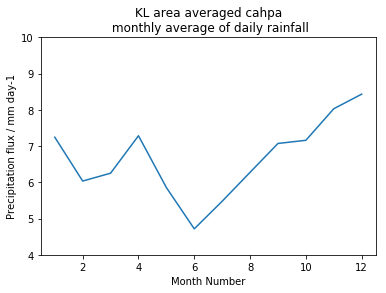

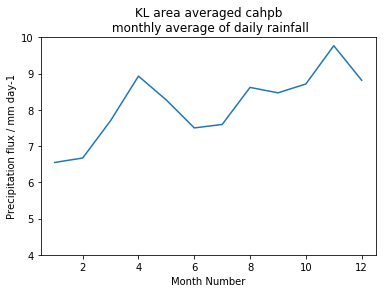

In [8]:
for jobid in ['cahpa', 'cahpb']:
    # Load the model cube
    inpath = os.path.join(DATADIR, 'climatology', jobid + '.mon.mean.1961_1990.pr.rr.mmday-1.KL.nc')
    cube = iris.load_cube(inpath)
    
    # Quick line plot for each cube 
    qplt.plot(cube.coord('month_number'), cube, label=jobid)
    plt.title('KL area averaged ' + jobid + '\n monthly average of daily rainfall')
    ax = plt.gca()
    ax.xaxis.set_label_text('Month Number')
    ax.set_xlim(0.5, 12.5)
    ax.set_ylim(4, 10)
    plt.show()

---
<div class="alert alert-block alert-success">
<b>Question:</b> Considering the plots of capha and cahpb data, note down their approximate values in mm day-1 for the following features: 

- Which month experiences the most rainfall? (also note the amount)
- If a second rainfall peak exists in another season, note the month and amount
- Which month experiences the least rainfall? (also note the amount)

What comparisons can be made about these two datasets?
</div>

<b>Answer:</b><br>
    
<b>HadCM3Q0 (cahpa)</b>
- Most rainfall: *month, amount*
- Secondary peak of rainfall:  *month, amount*
- Least rainfall:  *month, amount*

<b>ECHAM5 (cahpb)</b>
- Most rainfall: *month, amount*
- Secondary peak of rainfall:  *month, amount*
- Least rainfall:  *month, amount*

<b>How comparable are these datasets? How are they different?</b><br>


---

**e) Find the multi-annual monthly means (1961-1990) over the KL area for APHRODITE observations** by following the same methodology as above in step d)

In [9]:
# Load the KL extracted data created in previous step
infile = os.path.join(DATADIR, 'APHRODITE', 'aphro.mon.1961_1990.KL.nc')
aphrod = iris.load_cube(infile)

# Add monthly coord categorisation to the time dim coordinate
iris.coord_categorisation.add_month_number(aphrod, 'time', name='month_number')

# Now calculate monthly means
aphro_monthly_mean = aphrod.aggregated_by(['month_number'], iris.analysis.MEAN)

# create the area averaged monthly mean of daily rainfall
grid_areas = iris.analysis.cartography.area_weights(aphro_monthly_mean)
aphro_monthly_mean = aphro_monthly_mean.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)

# Save output
outfile = os.path.join(DATADIR, 'climatology', 'aphro.mon.mean.1961_1990.mmday-1.nc')
iris.save(aphro_monthly_mean, outfile)

/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [10]:
aphro_monthly_mean.coord_system()


---
<div class="alert alert-block alert-success">
<b>Question:</b> Plot the APHRODITE observations, compare with the HadCM3Q0 and ECHAM5 driven PRECIS runs. What are the differences between the observations and models; in which months are the differences greatest?
</div>

<b>Answer:</b><br>
*Write your findings here...*


---

<a id='3.3'></a>
## 3.3 Comparing models and observations

In Section 2.4 we saw how to plot model output on individual maps, but in order to do a rigorous comparison, **spatial model and observation fields must be on the same grid.**

**You should regrid to the coarsest resolution grid.** For the data used here, the observations have the coarsest resolution so we will regrid the model data onto the observation grid.

Recall that the PRECIS model data are on a grid known as a **Rotated Pole** coordinate system. The idea is that the "real" north pole in the Arctic is shifted such that the equator relative to our rotated pole then runs through the centre of the regional model domain.

**f) Regrid the multiannual OND mean model** fields onto the observations grid.

Here we use the `regrid` method to regrid the target cube. Here we will use linear interpolation. First, load in the data.


In [11]:
# directory where data is stored
data_path = os.path.join(DATADIR, 'climatology')

# load cahpa
infile = os.path.join(DATADIR, 'climatology', 'cahpa.OND.mean.1961_1990.pr.mmday-1.nc')
cahpa_model_cube = iris.load_cube(infile)
# load cahpb
infile = os.path.join(DATADIR, 'climatology', 'cahpb.OND.mean.1961_1990.pr.mmday-1.nc')
cahpb_model_cube = iris.load_cube(infile)
# load APHRODITE
infile = os.path.join(DATADIR, 'climatology', 'aphro.OND.mean.1961_1990.pr.mmday-1.nc')
obs_cube = iris.load_cube(infile)

Before we can regrid any data, both the model and observation datasets must have a **specified coordinate system**. 

In this case, APHRODITE's coordinate system is missing from the original netCDF file, but the observations are on a regular longitude-latitude grid so the correct coordinate system is [WGS84](https://epsg.io/32600/). 

In the code below, we define the WGS84 coordinate system and then apply it to the x- and y-axes (i.e. longitudes and latitudes) of the observations.  

The coordinate system used by the model (the rotated grid) is already defined.


In [12]:
# Define WGS84 projection for obs data
wgs84 = iris.coord_systems.GeogCS(semi_major_axis=6378137.0, inverse_flattening=298.257223563)

# Apply WGS84 to obs cube
obs_cube.coord(axis='x').coord_system = wgs84
obs_cube.coord(axis='y').coord_system = wgs84

# Print out and compare the two coordinate systems
print(obs_cube.coord_system())
print(cahpa_model_cube.coord_system())

GeogCS(semi_major_axis=6378137.0, semi_minor_axis=6356752.314245179)
RotatedGeogCS(75.0, 289.0, ellipsoid=GeogCS(6371229.0))


The next few lines of code **regrid the model data from rotated pole to the regular grid used by the observations**. 

From the plots created in section 2.4, we know that the area covered by APHRODITE data is larger than the PRECIS model domain. Hence, the **extrapolation mode** is set to `mask` so that any grid cells on the APHRODITE grid which do not overlap with model grid cells are masked `off`; otherwise, the model data would be interpolated and would produce misleading results.

In [19]:
# Regrid the climate model data onto APHRODITE grid
cahpa_regrid = cahpa_model_cube.regrid(obs_cube, iris.analysis.Nearest(extrapolation_mode='mask'))
cahpb_regrid = cahpb_model_cube.regrid(obs_cube, iris.analysis.Nearest(extrapolation_mode='mask'))

# Save output
iris.save(cahpa_regrid, data_path + '/cahpa.OND.mean.1961_1990.pr.mmday-1.rg.nc')
iris.save(cahpb_regrid, data_path + '/cahpb.OND.mean.1961_1990.pr.mmday-1.rg.nc')

print(obs_cube.shape)
print(cahpa_regrid.shape)

(1, 280, 360)
(1, 280, 360)


---
<div class="alert alert-block alert-success">
<b>Question:</b> Now that the cubes are all on the same grid, what differences do you see? <br> Complete the code template below to help answer this question.
</div>

**Hint:** You need to (i) load the NetCDF files, (ii) plot the APHRODITE and model data again (as in section 2.4) to compare them visually once again.

In [ ]:
# Directory name where data is read from
indir = os.path.join(DATADIR, 'climatology')

# load cahpa model data

# load cahpb model data

# load APHRODITE data

# Do some plotting!
plt.figure(figsize=(12, 10))

...

plt.show()

**Answer:**

_Write your findings here..._

---

**g) Find the difference between the model and the observation OND multiannual mean** fields and plot maps to view the differences

To find differences,  now that the model and observations are on the same grid we can simply subtract the model data from the observations.  

There is a subtract function within Iris but it cannot be used here.  The model cubes contain extra coordinates which are not present in the obs cube; Iris requires all coordinates within the cubes to match exactly.

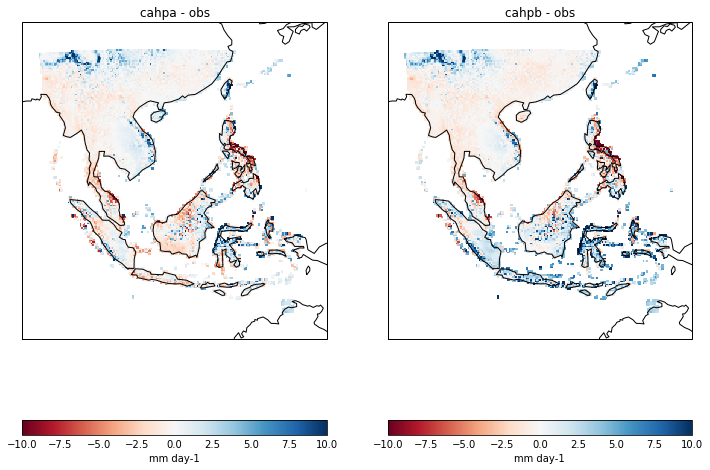

In [21]:
# Make sure units are the same
obs_cube.units = cahpb_regrid.units

# Make recieving cube
cahpa_obs_diff = obs_cube.copy()
cahpb_obs_diff = obs_cube.copy()

# Replace data with the differences
cahpa_obs_diff.data = cahpa_regrid.data - obs_cube.data
cahpb_obs_diff.data = cahpb_regrid.data - obs_cube.data

# Plotting
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)           # Create a new subplot for the first differences, 2 rows, 1 column, 1st plot

# Only plot the region containing data. We use the intersection method to do this.
qplt.pcolormesh(cahpa_obs_diff[0].intersection(longitude=(90, 135), latitude=(-20, 32)), 
                vmax=10, vmin=-10, 
                cmap=plt.get_cmap('RdBu')) # Note this is where cube slicing is needed as you can only plot 2-coordinate
                               # dimensions with qplt.contourf, so here we have selected time[0] as there is only
                               # one timestep (the baseline 1961-1990 mean)

plt.title('cahpa - obs')       # plots a title for the plot
ax = plt.gca()                 # gca function that returns the current axes
ax.coastlines()                # adds coastlines defined by the axes of the plot

plt.subplot(1, 2, 2)           # Create a new subplot for the model data 2 row, 2 columns, 2nd plot
qplt.pcolormesh(cahpb_obs_diff[0].intersection(longitude=(90, 135), latitude=(-20, 32)),
             vmax=10, vmin=-10,
             cmap=plt.get_cmap('RdBu'))

plt.title('cahpb - obs')       # plots a title for the plot
ax = plt.gca()                 # gca function that returns the current axes
ax.coastlines()                # adds coastlines defined by the axes of the plot

plt.show()

---
<div class="alert alert-block alert-success">
<b>Questions:</b> We have now created difference plots; to more easily validate the model(s) directly against observations. 
    
- Why has the data over the oceans disappeared?
- Which of the two model datasets (cahpa and cahpb) has the greatest wet bias? In which region? 
- Are there any areas in cahpa or cahpb with a strong dry bias? Roughly what is the extent of this bias (in mm/day)? 
</div>

<b>Answers</b>
- The data over the oceans has disappeared because [...] 

- The greatest wet bias occus in model [...], in region [...] 

- A strong dry bias exists in model [...] in region [...] (roughly [...] mm/day drier than APHRODITE observations).  

---

<a id='3.4'></a>
## 3.4 Climatological mean and annual cycle for an ensemble

So far data from two models downscaled with PRECIS have been analysed. In this section we will look at some addional HadCM3 ensemble memebers and the CRU bservational data set. 

The CRU data are a monthly global land-only dataset (1901-present) at 0.5 degree resolution. Nine variables are available, including mean, min, max temperature and precipitation. For further details please see: http://www.cru.uea.ac.uk/~timm/grid/CRU_TS_2_1.html

This gives us an ensemble of RCM data:

* HadCM3Q0 (cahpa)
* ECHAM5 (cahpb)
* HadCM3Q3 (cahpc)
* HadCM3Q10 (cahpd)
* HadCM3Q11 (cahpe)
* HadCM3Q13 (cahpf)

And observational datasets:

* APHRODITE
* CRU

Taking an ensemble approach allows us to account for a range of uncertainty in the model projections.

Write a series of scripts to do the following:

**h) Calculate the OND seasonal mean and annual cycle** (for the KL area) for 1.5m temperature and precipitation for CRU and APHRODITE observations

**i) Calculate OND seasonal-mean and monthly-mean anomalies** for the KL area for the 4 additional HadCM3Q ensemble members (cahpc, cahpd, cahpe & cahpf)

**j) Plot a series of figures** that shows 1) the monthly cycles of temperature and rainfall comparing the 6 models and the observations; and 2) the monthly differences between the models and observations

In [ ]:
'''
Here are some useful varibles  you might like to use in your scripts
'''
# Some helpful data locations
DATADIR = '/project/precis/worksheets/data'
APHRODIR = os.path.join(DATADIR, 'APHRODITE')
CRUDIR = os.path.join(DATADIR, 'CRU')
CLIMDIR = os.path.join(DATADIR, 'climatology')
MODELDIR = os.path.join(DATADIR, 'netcdf')

# Some helpful model variables
JOBID = ['cahpa', 'cahpb', 'cahpc', 'cahpd', 'cahpe', 'cahpf']
STASHCODES = ['03236', '05216'] # 03236 = temperature, 05216 = precipitation

# Kuala Lumpur domains...
# ... in rotated pole coordinates
grid_longitude=(-8.17, -7.43)
grid_latitude=(-12.10, -11.38)
# ... in true lat-lon coordiates
longitude=(101.25, 102.15)
latitude=(2.74, 3.48)

In [ ]:
'''
h) Calculate the OND seasonal-mean and monthly-mean 1.5m temperature and precipitation 
for the KL area, for CRU and APHRODITE observations
'''
# Load APHRODITE data

# Load CRU data

# Extract KL area

# Add OND season catagorisation

# Add monthly catagorisation

# Extract season

# Aggregate cubes

# Find KL area average

# Check and add cube metadata

# Save cubes to CLIMDIR
# Remember to use the same naming convention we used earlier


In [ ]:
'''
i) Calculate OND seasonal-mean and monthly-mean anomalies for the KL area 
for the 4 additional HadCM3Q ensemble members (cahpc, cahpd, cahpe & cahpf)
'''
# Load ensemble members
# Remember you need to do this for both precipitation AND temperature

# Regrid ensemble members onto observational grid
# Remember you need to check your model and obs cubes have the appropriate coordinate systems defined

# Extract the KL area. Remember you are now working in true lat-lon coordinates!

# Find OND and monthly means

# Calculate model anomalies
# Remember temp anomaly   = model - CRU data
#          precip anomaly = model - APHRO data

# Check cube metadata consistency and save


---
<div class="alert alert-block alert-success">
    <b>Question:</b> What difference would it make if we first extracted the KL area and <em>then</em> regrid the models? <br> 
Which order is best for preserving data integrity?
</div>

<b>Answer:</b><br> 

---

Create four figures:
    
    i) the monthly cycle of temperature (model and observations) 
    ii) the monthly cycle of rainfall (model and observations)
    iii) the monthly temperature anomaly for each model
    iv) the monthly precipitation anomaly for each model

In [ ]:
'''
Plot 1: The monthly cycle of temperature (model and observations)
'''


In [ ]:
'''
Plot 2: The monthly cycle of precipitation (model and observations)
'''


In [ ]:
'''
Plot 3: The monthly temperature anomaly for each model
'''


In [ ]:
'''
Plot 4: The monthly precipitation anomaly for each model
'''


---
<div class="alert alert-block alert-success">
    <b>Question:</b> How could you summarise the ensemble variability amongst model members in a plot?
</div>

<b>Answer:</b><br> 
    

<div class="alert alert-block alert-success">
    <b>Question:</b> How does the monthly temperature and precipitation anomaly compare to the OND average?
</div>

<b>Answer:</b><br> 
    

<div class="alert alert-block alert-success">
<b>Question:</b> What are the advantages and disadvantages of plotting spatial maps of temperature and rainfall variability over Kuala Lumpur?
</div>

<b>Answer:</b><br> 

---


<div class="alert alert-block alert-warning">
<center><b>This completes worksheet 3.</b></center><br>
    You have used Python and Iris to validate the model's climatology (30 years of baseline data: 1961-1990) against observations, in order to analyse the model's capability of representing real-world trends. <br>
To do so, you have:
    
- calculated and plotted multiannual seasonal and monthly mean data,
- regridded rotated pole model data to a regular latitude-longitude grid,
- created difference plots to compare model data with observations, and 
- written your own code to do all of these post-processing and analysis tasks with an multi-model ensemble!<br>

In worksheet 4, you will consider future model projections and their changes with respect to the baseline period (calculated in this worksheet).
</div>

<center>© Crown Copyright 2018, Met Office </center>